# 第5章の Chainer 版

本ノートブックは、waifu2x を Chainer で再現したものです。
Torch7 で実装されたオリジナルの waifu2x は CUDA の実行環境が必須でしたが、本ノートブックは GPU が無い環境でも実行できます。

## 準備

ノートブックの実行環境を準備します。準備している内容は第2章のノートブックと同じです。

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rcParams['font.family'] = [u'Osaka']
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
import sys
import numpy as np
import pandas as pd
from PIL import Image
import chainer
import chainer.functions as F
import chainer.optimizers
from chainer import cuda
import json
import six
import math

In [4]:
gpu_device_id = 0
try:
    cuda.init(gpu_device_id)
    use_gpu = True
    print "GPU %d is available." % (gpu_device_id)
except:
    use_gpu = False
    print "GPU %d is not available." % (gpu_device_id)
    print "Error: ", sys.exc_info()[0], sys.exc_info()[1]

GPU 0 is available.


## モデルのロードとニューラルネットワークの作成

waifu2x のモデルファイルを利用し、Chainer で waifu2x のニューラルネットワークを生成します。
モデルファイルは waifu2x のリポジトリに含まれている JSON 形式のものを利用します。

In [5]:
with open('waifu2x/models/anime_style_art_rgb/scale2.0x_model.json') as fp:
    model_params = json.load(fp)

ロードしたモデルを解釈して、ニューラルネットワークを作成します。
以下で定義している `make_Convolution2D` 関数は、waifu2x のモデルの畳み込み層のパラメータから Chainer の `Convolution2D` を作成します。

In [6]:
def make_Convolution2D(params):
    func = F.Convolution2D(
        params['nInputPlane'],
        params['nOutputPlane'],
        (params['kW'], params['kH'])
    )
    func.b = np.float32(params['bias'])
    func.W = np.float32(params['weight'])
    return func

model = chainer.FunctionSet()
for i, layer_params in enumerate(model_params):
    function = make_Convolution2D(layer_params)
    setattr(model, "conv{}".format(i + 1), function)

if use_gpu:
    model.to_gpu()

steps = len(model_params)
pad_size = steps*2

以下の `forward` 関数は、引数で与えた入力データをニューラルネットワークに通して出力データを生成し、出力データと隠れ層の出力が記録された辞書を返します。

In [7]:
def forward(x):
    h = x
    hidden_layers = {}
    for i in range(1, steps):
        key = 'conv{}'.format(i)
        h = F.leaky_relu(getattr(model, key)(h), 0.1)
        hidden_layers[key] = cuda.to_cpu(h.data)
    key = 'conv{}'.format(steps)
    y = getattr(model, key)(h)
    hidden_layers[key] = cuda.to_cpu(y.data)
    return y, hidden_layers

## waifu2x の再現

Chainer を使って作成した waifu2x のニューラルネットワークを用いて、waifu2x の処理全体をステップ・バイ・ステップで再現します。

まずは画像をロードします。

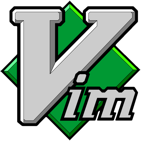

In [8]:
image = Image.open("vimlogo-141x141.png").convert("RGB")
image

次に、画像を最近傍補間で縦横2倍に拡大します。

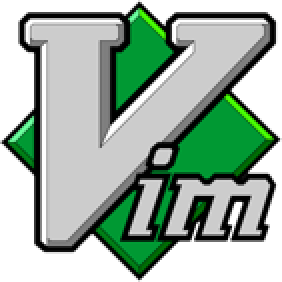

In [9]:
image2x = image.resize((2*image.size[0], 2*image.size[1]), resample=Image.NEAREST)
image2x

次は、2倍画像を NumPy のベクトルに変換し、ブロックサイズを128としてパディングを挿入します。
パディングを挿入する際は、画像がブロックサイズで丁度良く分割できるよう調整するため、右辺と下辺が、左辺と上辺よりも広いパディングが挿入されます。

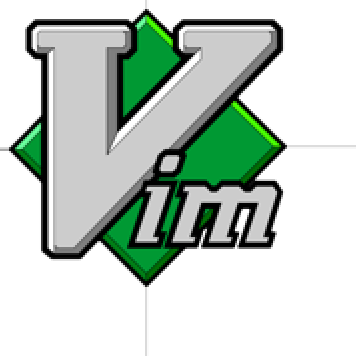

In [10]:
x_data = np.asarray(image2x).transpose(2, 0, 1).astype("float32")
x_data /= 255

# ブロックサイズ
block_size = 128
# ブロックを重ねるピクセル数 (== 畳み込み層の数)
block_offset = steps
# 出力サイズ
output_size = block_size - block_offset*2

# 垂直方向のブロック数
h_blocks = int(math.floor(x_data.shape[1] / output_size)) + (0 if x_data.shape[1] % output_size == 0 else 1)
# 水平方向のブロック数
w_blocks = int(math.floor(x_data.shape[2] / output_size)) + (0 if x_data.shape[2] % output_size == 0 else 1)

# パディングを含めた場合の高さ h と幅 w
h = block_offset + h_blocks * output_size + block_offset
w = block_offset + w_blocks * output_size + block_offset

# パディングのサイズ (上: pad_h1, 左: pad_w1, 下: pad_h2, 右: pad_w2)
pad_h1 = block_offset
pad_w1 = block_offset
pad_h2 = (h - block_offset) - x_data.shape[1]
pad_w2 = (w - block_offset) - x_data.shape[2]

# パディングの挿入
x_data = np.pad(x_data, ((0, 0), (pad_h1, pad_h2), (pad_w1, pad_w2)), "edge")

# パディング挿入後の状態を画像へ変換 (可視化のため)
Image.fromarray(np.uint8(x_data * 255).transpose(1, 2, 0))

誌面に掲載した部分をブロックとして使用するために、`x_data` から対象領域を抽出し、変数 `block` に入れます。

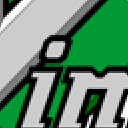

In [11]:
# ブロックを取り出す
block = x_data[:, 114:(114 + block_size), 114:(114 + block_size)]
# ミニバッチのインデックスとなる次元を追加する
block = np.reshape(block, (1,) + block.shape)

# 可視化のため、ブロックを画像へ変換
block_image = Image.fromarray(np.uint8(block[0] * 255).transpose(1, 2, 0))

# GPU が使用できる場合は block を GPU へ対応させる
if use_gpu:
    block  = cuda.to_gpu(block)

# 画像の可視化のため
block_image

変数 `block` を `chainer.Variable` へ変換し、ニューラルネットワークに通して出力データを生成します。

In [12]:
x = chainer.Variable(block)
y, hidden_layers = forward(x)
y_data = cuda.to_cpu(y.data)[0]

出力データに対する後処理として、0未満の値を0に、1を越える値を1に制限します。

In [13]:
y_data[y_data < 0] = 0
y_data[y_data > 1] = 1

`y_data` には超解像の結果が入っています。

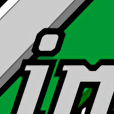

In [14]:
Image.fromarray(np.uint8(y_data * 255).transpose(1, 2, 0))

また、`hidden_layers` には隠れ層の出力が入っています。隠れ層の出力は、以下の `visualize_hidden_layer` 関数を使って可視化します。

In [15]:
# 隠れ層を可視化するための関数
def visualize_hidden_layer(data, padsize=1, padval=0, shape=None, gamma=1.0):
    if shape:
        nrows, ncols = shape
    else:
        ncols = int(np.ceil(np.sqrt(data.shape[0])))
        nrows = int(np.ceil(float(data.shape[0]) / ncols))

    image_width  = ncols * data.shape[2] + padsize * (ncols - 1)
    image_height = nrows * data.shape[1] + padsize * (nrows - 1)
    image = Image.new('L', (image_width, image_height), padval*255)

    for i in range(0, nrows):
        for j in range(0, ncols):
            k = i * ncols + j
            if k < data.shape[0]:
                patch = data[k].reshape(data.shape[1:3])
                patch -= patch.min()
                patch /= patch.max()
                patch = np.power(patch, gamma)
                patch = np.uint8(patch * 255)
                image.paste(Image.fromarray(patch), (j*(data.shape[2] + padsize), i*(data.shape[1] + padsize)))

    return image

### 1つ目の隠れ層の出力

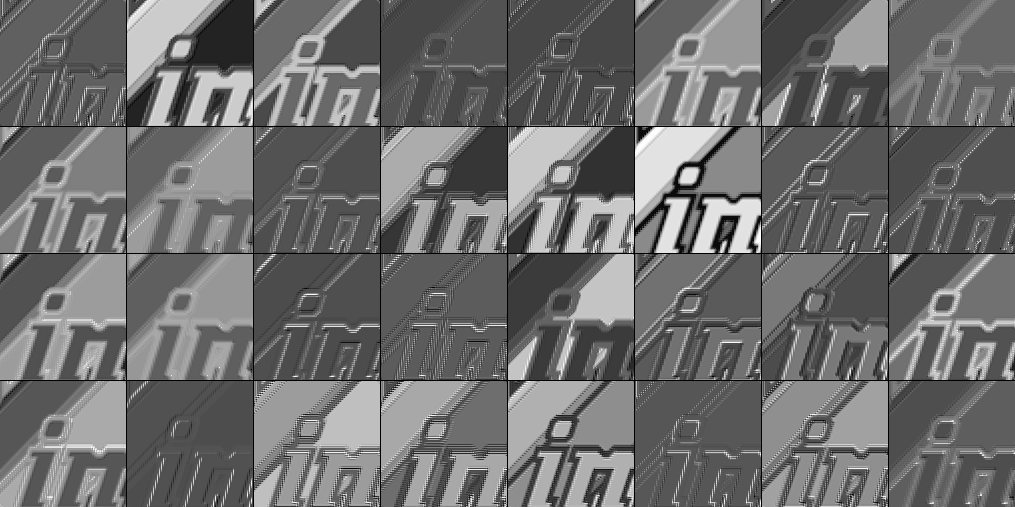

In [16]:
visualize_hidden_layer(hidden_layers['conv1'][0], shape=(4, 8), gamma=0.5)

### 2つ目の隠れ層の出力

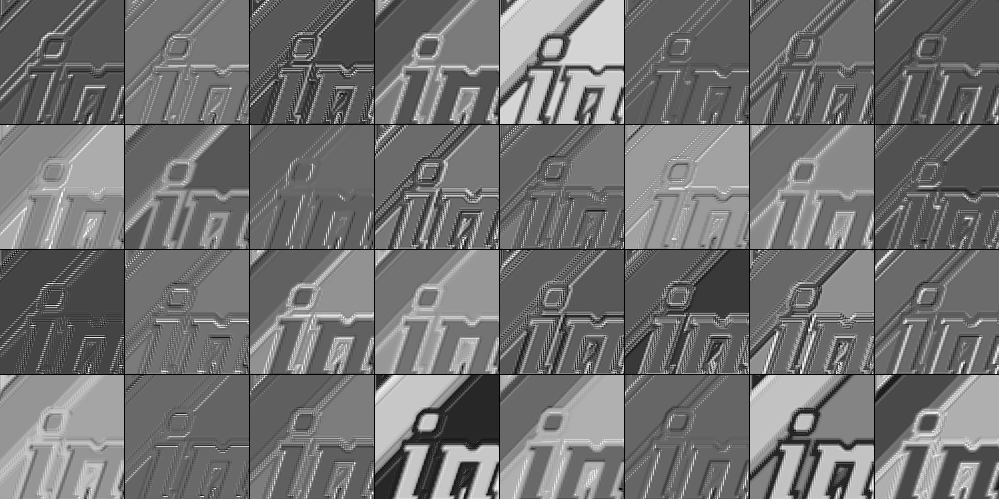

In [17]:
visualize_hidden_layer(hidden_layers['conv2'][0], shape=(4, 8), gamma=0.5)

### 3つ目の隠れ層の出力

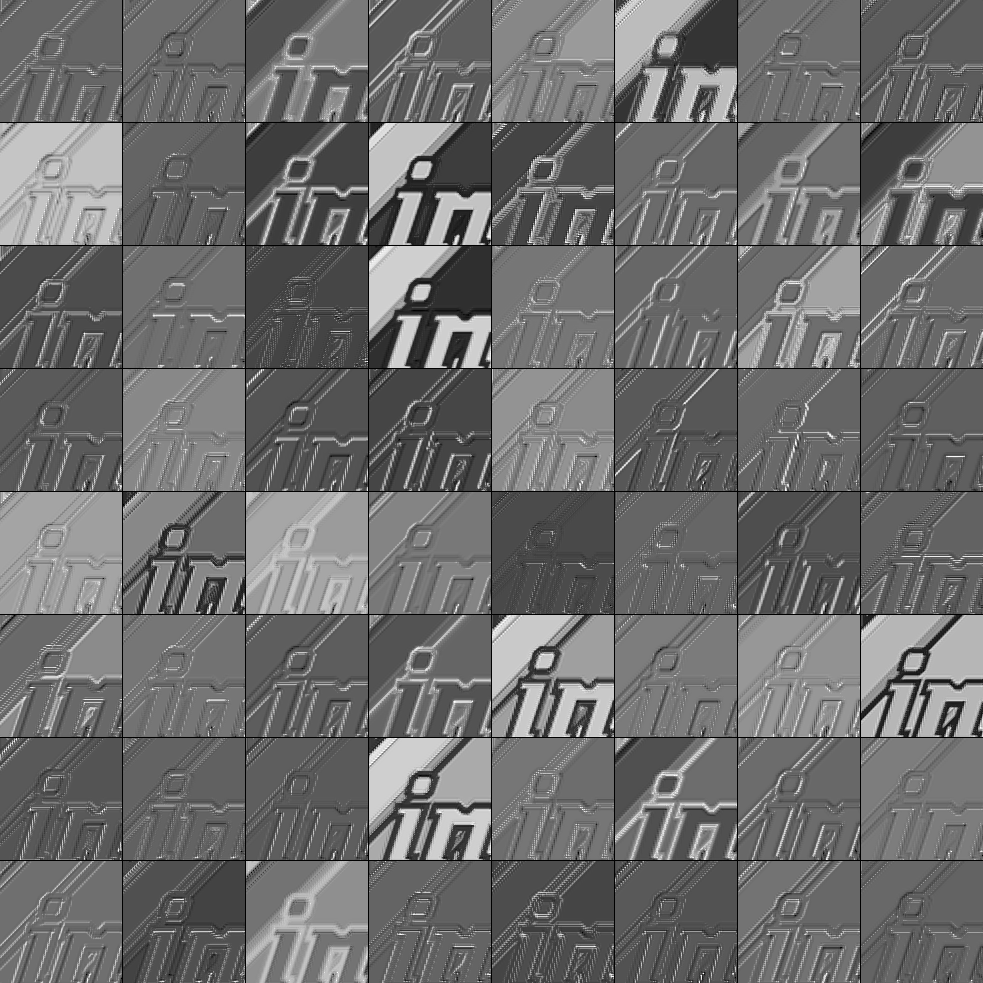

In [18]:
visualize_hidden_layer(hidden_layers['conv3'][0], gamma=0.5)

### 4つ目の隠れ層の出力

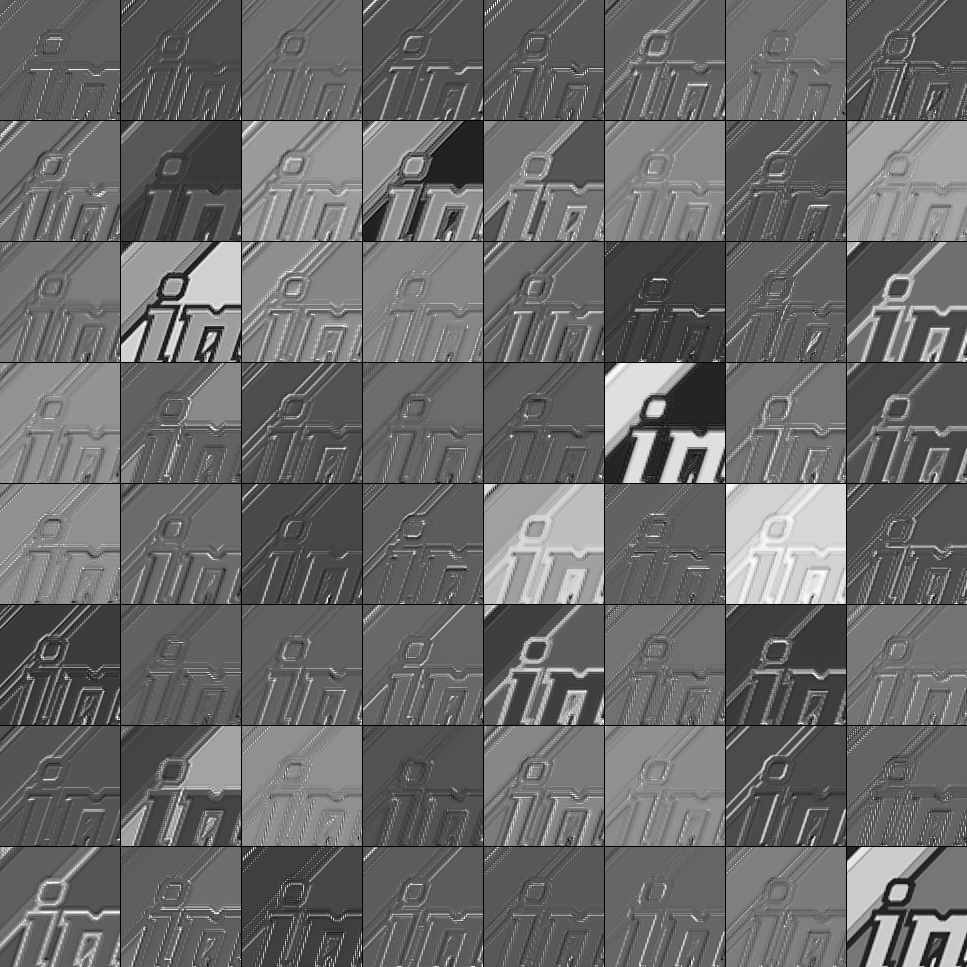

In [19]:
visualize_hidden_layer(hidden_layers['conv4'][0], gamma=0.5)

### 5つ目の隠れ層の出力

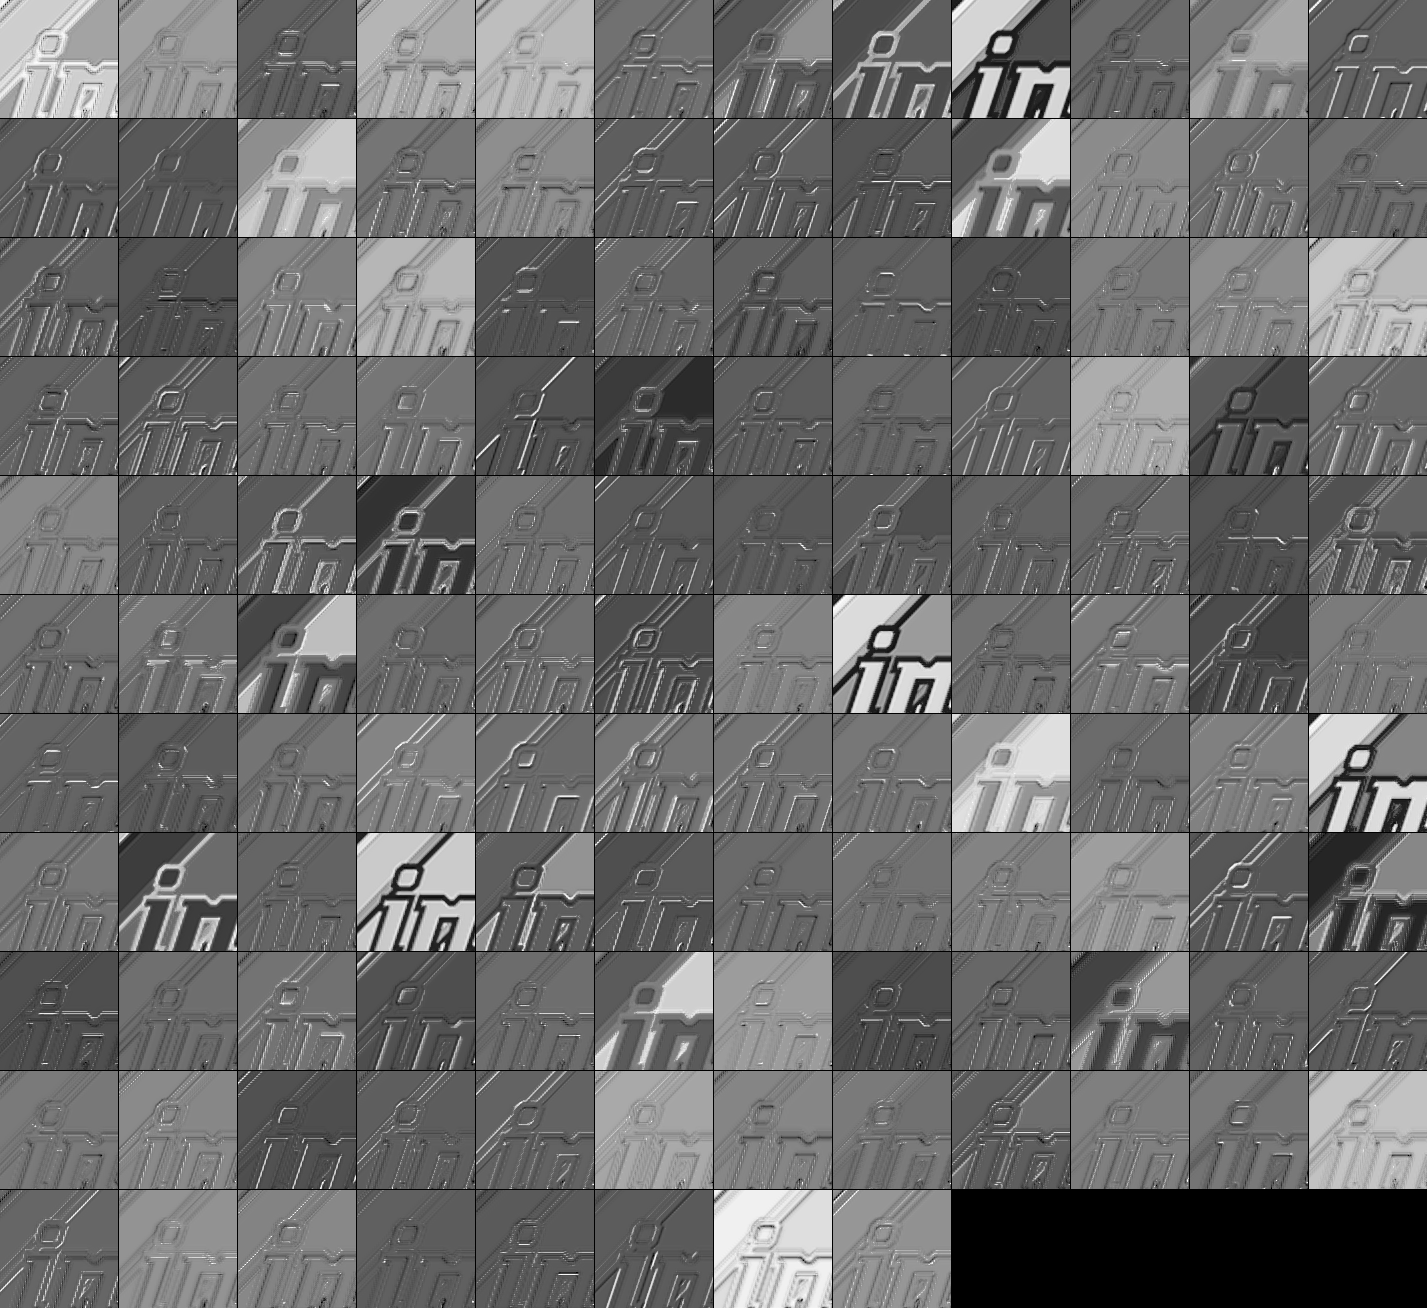

In [20]:
visualize_hidden_layer(hidden_layers['conv5'][0], gamma=0.5)

### 6つ目の隠れ層の出力

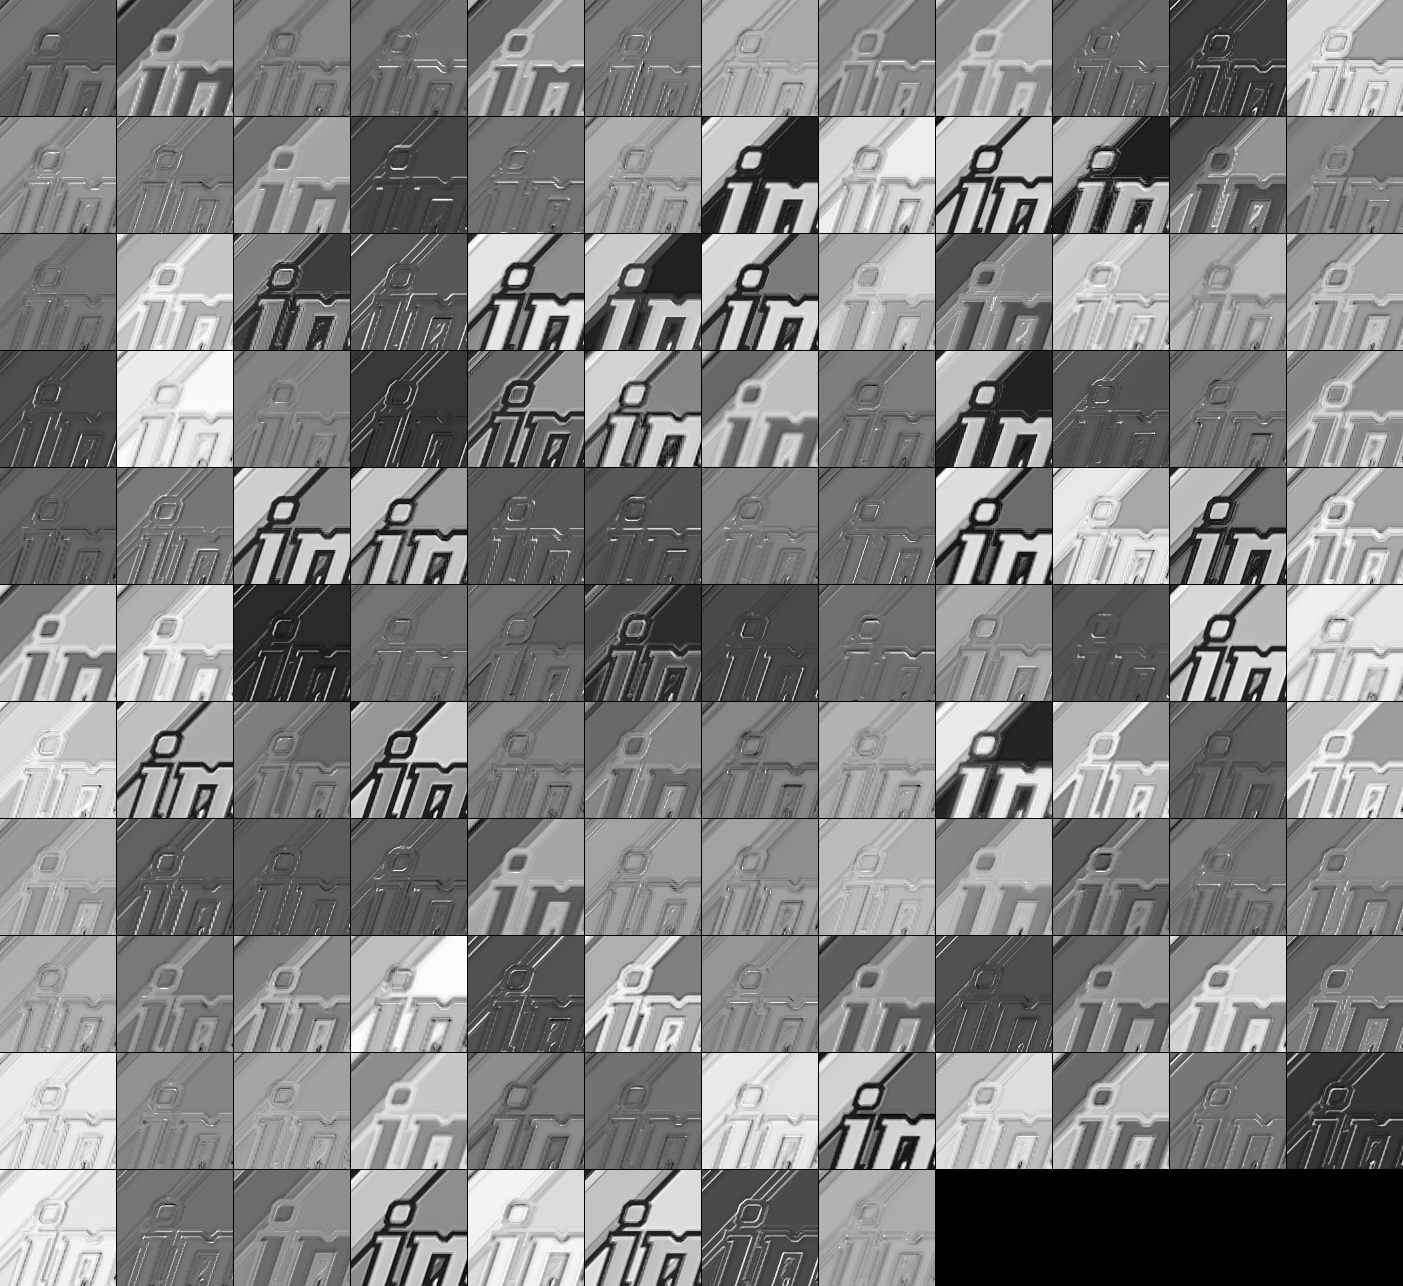

In [21]:
visualize_hidden_layer(hidden_layers['conv6'][0], gamma=0.5)

### 出力層の出力

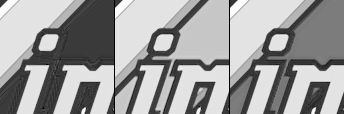

In [22]:
visualize_hidden_layer(hidden_layers['conv7'][0], shape=(1, 3), gamma=0.5)

## 全処理の統合

入力画像からブロックを切り出し、ニューラルネットワークに与えてブロックの超解像結果を生成し、すべてのブロック出力を組合せて結果画像を構成するまでを単一の関数 `scale_image` としてまとめます。

In [23]:
def scale_image(image, block_offset, block_size=128):
    image = image.resize((2*image.size[0], 2*image.size[1]), resample=Image.NEAREST)
    x_data = np.asarray(image).transpose(2, 0, 1).astype("float32")
    x_data /= 255

    output_size = block_size - block_offset*2
    h_blocks = int(math.floor(x_data.shape[1] / output_size)) + (0 if x_data.shape[1] % output_size == 0 else 1)
    w_blocks = int(math.floor(x_data.shape[2] / output_size)) + (0 if x_data.shape[2] % output_size == 0 else 1)

    h = block_offset + h_blocks * output_size + block_offset
    w = block_offset + w_blocks * output_size + block_offset
    pad_h1 = block_offset
    pad_w1 = block_offset
    pad_h2 = (h - block_offset) - x_data.shape[1]
    pad_w2 = (w - block_offset) - x_data.shape[2]

    x_data = np.pad(x_data, ((0, 0), (pad_h1, pad_h2), (pad_w1, pad_w2)), "edge")
    result_data = np.zeros_like(x_data)
    hidden_layers = {}

    for i in range(0, x_data.shape[1], output_size):
        if i + block_size > x_data.shape[1]:
            continue
        for j in range(0, x_data.shape[2], output_size):
            if j + block_size > x_data.shape[2]:
                continue
            block = x_data[:, i:(i + block_size), j:(j + block_size)]
            block = np.reshape(block, (1,) + block.shape)
            if use_gpu:
                block = cuda.to_gpu(block)

            x = chainer.Variable(block)
            y, hl = forward(x)
            y_data = cuda.to_cpu(y.data)[0]
            hidden_layers[(i, j)] = hl

            result_data[:,
                        (i + block_offset):(i + block_offset + output_size),
                        (j + block_offset):(j + block_offset + output_size)] = y_data

    result_data = result_data[:,
                              (pad_h1 + 1):(result_data.shape[1] - pad_h2 - 1),
                              (pad_w1 + 1):(result_data.shape[2] - pad_w2 - 1)]
    result_data[result_data < 0] = 0
    result_data[result_data > 1] = 1
    result_data *= 255

    result_image = Image.fromarray(np.uint8(result_data).transpose(1, 2, 0))
    return result_image, hidden_layers

実行してみましょう。

再び入力画像の確認です。

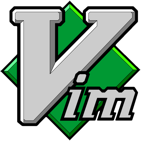

In [24]:
image = Image.open("vimlogo-141x141.png").convert("RGB")
image

次に、超解像結果の確認です。

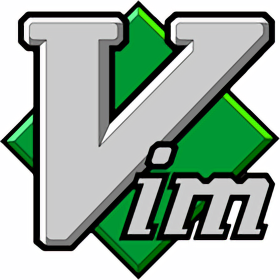

In [25]:
scaled_image, hidden_layers = scale_image(image, steps)
scaled_image

入力画像と出力画像のサイズを確認します。

In [26]:
image.size

(141, 141)

In [27]:
scaled_image.size

(280, 280)

2倍に拡大されていますね。

最後に、`scaled_image` をさらに2倍に超解像してみましょう。

(558, 558)


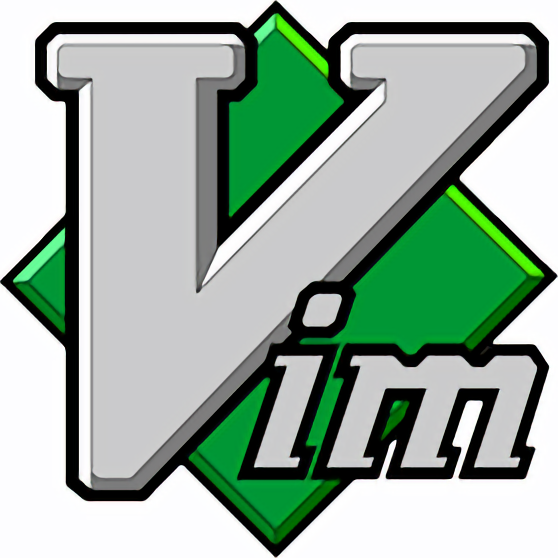

In [28]:
scaled_image4x = scale_image(scaled_image, steps)[0]
print scaled_image4x.size
scaled_image4x